In [23]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from importlib.metadata import version
from statannot import add_stat_annotation
import statannot
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.tools import pinv_extended  
from statsmodels.stats.anova import anova_lm
import pingouin as pg

# set rcParams to be able to easily edit text in illustrator
plt.rcParams.update({
    'pdf.fonttype': 42,
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
})
sns.set_context("notebook", font_scale=1.5)

# versions

In [2]:
packages = ['pandas', 'matplotlib', 'seaborn', 'numpy', 'pingouin', 'statsmodels', 'statannot']
for package in packages:
    print(f"{package} version: {version(package)}")

pandas version: 2.2.1
matplotlib version: 3.8.4
seaborn version: 0.12.2
numpy version: 1.26.4
pingouin version: 0.5.4
statsmodels version: 0.14.0
statannot version: 0.2.3


# data

In [3]:
loco1 = pd.read_excel("/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/data/locomotion_adulthood_only_cohort.xlsx")
loco2 = pd.read_excel("/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/data/locomotion_longitudinal_cohort.xlsx")
anxiety1 = pd.read_excel("/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/data/anxiety_adulthood_only_cohort.xlsx")
anxiety2 = pd.read_excel("/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/data/anxiety_longitudinal_cohort.xlsx")
ppi_nor = pd.read_excel("/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/data/PPI_NOR_adulthood_only_cohort.xlsx")

In [4]:
dfs = [loco1, loco2, anxiety1, anxiety2, ppi_nor]

for df in dfs:
    # standardizing dfs
    if 'sex' in df.columns:
        df.rename(columns={'sex': 'Sex'}, inplace=True)
    # replace 'HOM' with 'KO' in 'Group_ID' column
    if 'Group_ID' in df.columns:
        df['Group_ID'] = df['Group_ID'].replace('HOM', 'KO')

# anxiety plots

In [5]:
# separate anxiety dataframes by sex
anxiety_groups = {
    "anxiety1M": anxiety1[anxiety1['Sex'] == 'M'],
    "anxiety1F": anxiety1[anxiety1['Sex'] == 'F'],
    "anxiety2M": anxiety2[anxiety2['Sex'] == 'M'],
    "anxiety2F": anxiety2[anxiety2['Sex'] == 'F']
}

In [6]:
# calculate anxiety z scores delative to WT mean and std
def calculate_z_scores(df, columns_to_transform):
    wt_group = df[df['Group_ID'] == 'WT']
    ko_group = df[df['Group_ID'] == 'KO']
    wt_mean, wt_std = wt_group[columns_to_transform].mean(), wt_group[columns_to_transform].std() 
    ko_group[columns_to_transform] = (ko_group[columns_to_transform] - wt_mean) / wt_std
    return ko_group

In [7]:
# apply to all anxiety groups
for key in anxiety_groups.keys():
    columns_to_transform = anxiety_groups[key].columns[3:]  # excluding metadata columns
    anxiety_groups[key] = calculate_z_scores(anxiety_groups[key], columns_to_transform)

/var/folders/r9/_1bw8v7j4dqb79r_rydnls7c0000gn/T/ipykernel_86311/3678061873.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ko_group[columns_to_transform] = (ko_group[columns_to_transform] - wt_mean) / wt_std


In [8]:
# define colour palettes in a bit of a hacky way since don't know how to have two palettes for two pointplots otherwise
point_palette = {
    'OF_duration_core': '#cba0ae', 'OF_duration_centre': '#cba0ae', 'EPM_duration_open': '#cba0ae',
    'EPM_duration_middle': '#cba0ae', 'EPM_bouts_open': '#cba0ae', 'EPM_dips': '#cba0ae',
    'OF_duration_periphery': '#cba0ae', 'OF_latency_core': '#cba0ae', 'OF_latency_centre': '#cba0ae',
    'EPM_latency_open': '#cba0ae', 'EPM_duration_closed': '#cba0ae', 'EPM_saps': '#cba0ae'
}

point_palette_x = {key: '#915e95' for key in point_palette.keys()}


In [9]:
# how to plot anxiety
def plot_anxiety(df1, df2, title, output_file):
    columns_to_plot1, columns_to_plot2 = df1.columns[3:], df2.columns[3:]
    desired_order = list(point_palette.keys())

    plt.figure(figsize=(4, 2))
    plt.axhline(y=0, color='#c0bec2', linestyle='-', linewidth=4, zorder=0)

    sns.pointplot(data=df1[columns_to_plot1], scale=1.5, capsize=0, palette=point_palette_x, orient='v', errorbar=('ci', 95), order=desired_order)
    sns.pointplot(data=df2[columns_to_plot2], scale=1.5, capsize=0, palette=point_palette, orient='v', errorbar=('ci', 95), order=desired_order)

    plt.xlabel("Z score relative to control")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylim([-4, 4])
    sns.despine()
    plt.savefig(output_file)
    plt.show()


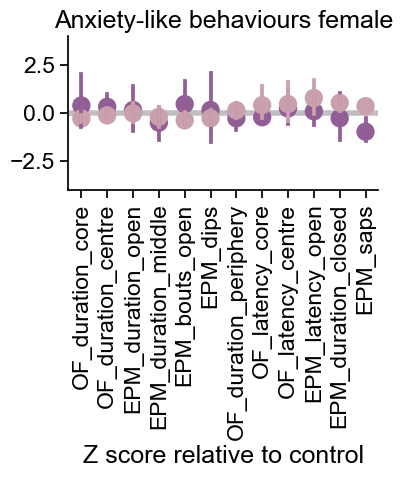

In [10]:
plot_anxiety(anxiety_groups['anxiety1F'], anxiety_groups['anxiety2F'], "Anxiety-like behaviours female",
             '/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/female_anxiety.pdf')

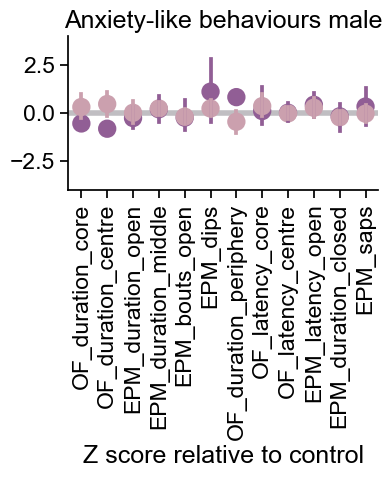

In [11]:
plot_anxiety(anxiety_groups['anxiety1M'], anxiety_groups['anxiety2M'], "Anxiety-like behaviours male",
             '/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/male_anxiety.pdf')

# locomotion plots

In [12]:
loco_columns = [
    'OF_loco_speed',
    'OF_loco_total_duration',
    'OF_loco_total_dist',
    'EPM_loco_speed',
    'EPM_loco_duration',
    'EPM_loco_distance'
]


In [13]:
# separate loco dataframes by sex
loco_groups = {
    "loco1M": loco1[loco1['Sex'] == 'M'],
    "loco1F": loco1[loco1['Sex'] == 'F'],
    "loco2M": loco2[loco2['Sex'] == 'M'],
    "loco2F": loco2[loco2['Sex'] == 'F']
}

In [14]:
# apply to all loco groups
for key in loco_groups.keys():
    columns_to_transform = loco_groups[key].columns[3:]  # excluding metadata columns
    loco_groups[key] = calculate_z_scores(loco_groups[key], columns_to_transform)

/var/folders/r9/_1bw8v7j4dqb79r_rydnls7c0000gn/T/ipykernel_86311/3678061873.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ko_group[columns_to_transform] = (ko_group[columns_to_transform] - wt_mean) / wt_std


In [15]:
loco_palette_x = {
    'OF_loco_speed': '#cba0ae',
    'OF_loco_total_duration': '#cba0ae',
    'OF_loco_total_dist': '#cba0ae',
    'EPM_loco_speed': '#cba0ae',
    'EPM_loco_duration': '#cba0ae',
    'EPM_loco_distance': '#cba0ae'
}

loco_palette = {key: '#915e95' for key in loco_palette_x.keys()}

In [16]:
def plot_loco(df1, df2, title, output_file):
    columns_to_plot1, columns_to_plot2 = df1.columns[3:], df2.columns[3:]
    desired_order = list(loco_palette.keys())

    plt.figure(figsize=(3, 2))
    plt.axhline(y=0, color='#c0bec2', linestyle='-', linewidth=4, zorder=0)

    sns.pointplot(data=df1[columns_to_plot1], scale=1.5, capsize=0, palette=loco_palette_x, orient='v', errorbar=('ci', 95), order=desired_order)
    sns.pointplot(data=df2[columns_to_plot2], scale=1.5, capsize=0, palette=loco_palette, orient='v', errorbar=('ci', 95), order=desired_order)

    plt.xlabel("Z score relative to control")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylim([-3, 3])
    sns.despine()
    plt.savefig(output_file)
    plt.show()


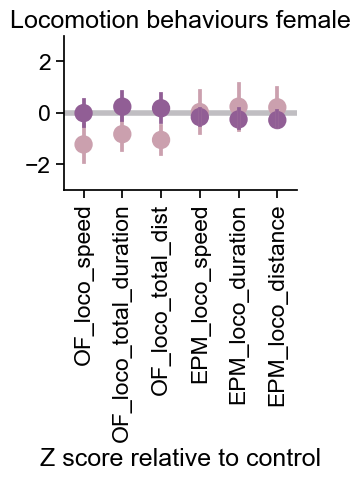

In [17]:
plot_loco(loco_groups['loco1F'], loco_groups['loco2F'], "Locomotion behaviours female", 
          '/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/female_locomotion.pdf')


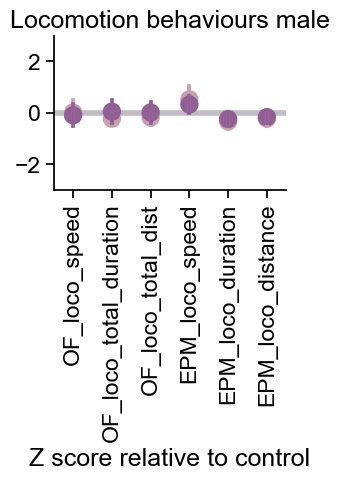

In [18]:
plot_loco(loco_groups['loco1M'], loco_groups['loco2M'], "Locomotion behaviours male", 
          '/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/male_locomotion.pdf')

# adulthood-only mean separation plots

In [19]:
def plot_events(dataframe, y_column, file_path, ylim=None, title=None, ylabel=None):
    # creation of figure and axis
    f, ax = plt.subplots(figsize=(2, 2))

    # define the desired order for 'Sex'
    desired_order = ['M', 'F']

    # define the color palette for Group_ID and Sex
    palette = {
        ('WT', 'M'): '#c0bec2',  
        ('WT', 'F'): '#c0bec2', 
        ('KO', 'M'): '#cba0ae',  
        ('KO', 'F'): '#cba0ae'   
    }
    # manually plot data points with custom markers
    marker_size = 60  # size of markers
    x_spacing = 0.1  # spacing between 'WT' and 'KO' markers within each sex

    for i, sex in enumerate(desired_order):
        # filter data for the current group
        sex_data = dataframe[dataframe['Sex'] == sex]

        # calculate x-coordinate for scatter plot based on the desired order
        x_position = i

        for j, row in sex_data.iterrows():
            # determine x-coordinate based on group_ID (this is genotype)
            x_offset = -x_spacing / 0.6 if row['Group_ID'] == 'WT' else x_spacing / 0.6

            # calculate final x-coordinate with offset
            x_coordinate = x_position + x_offset

            # determine marker and color based on 'Group_ID'
            marker = 'o' if sex == 'M' else 'o'
            color = palette[(row['Group_ID'], sex)]

            # plot scatter points
            ax.scatter(x_coordinate, 
                       row[y_column], 
                       linewidth=1.5,
                       color=color,
                       facecolor='none', 
                       marker=marker, 
                       s=marker_size, 
                       alpha=0.3)


    # plot the pointplot with custom markers
    sns.pointplot(x='Sex', 
                  y=y_column, 
                  markers=['o', 'o'], 
                  hue='Group_ID', 
                  palette={'WT': '#c0bec2', 'KO': '#cba0ae'}, 
                  hue_order=['WT', 'KO'],
                  order=desired_order, 
                  dodge=0.35,
                  data=dataframe, 
                  ax=ax,
                  errorbar=('ci', 95), 
                  capsize=0.2, 
                  scale=1.5, 
                  join=False, 
                  errwidth=2.25)


 # add statistical annotations for all four comparisons
    box_pairs = [
        (('M', 'WT'), ('M', 'KO')),
        (('F', 'WT'), ('F', 'KO')),
        (('M', 'KO'), ('F', 'KO')),
        (('F', 'WT'), ('M', 'KO'))
    ]
    test_order=['WT', 'KO']
    add_stat_annotation(ax, perform_stat_test=True, 
                        order=desired_order, 
                        hue_order=test_order,
                        data=dataframe, 
                        x='Sex', y=y_column, 
                        hue='Group_ID', 
                        box_pairs=box_pairs,
                        test='Kruskal', 
                        pvalues=None, 
                        text_format='star', 
                        loc='inside', verbose=2, 
                        comparisons_correction='bonferroni')

    # remove axes
    sns.despine()

    # set lims and labels
    ax.set_xlim(-1, 2)
    if ylim:
        ax.set_ylim(*ylim)
    if title:
        ax.set_title(title)
    if ylabel:
        ax.set_ylabel(ylabel)

    tick_positions = range(len(desired_order))
    ax.set_xticks(tick_positions)
    tick_labels = ['Male', 'Female']  # 

    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('')

    plt.savefig(file_path, bbox_inches='tight')
    plt.gca().get_legend().remove()





p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

F_WT v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.481e-01
M_WT v.s. M_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.858e-01
M_KO v.s. F_WT: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.705e-01
M_KO v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.439e-01


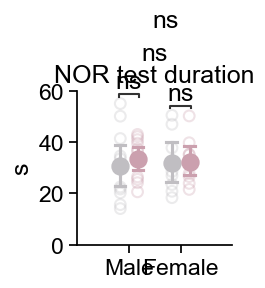

In [20]:
plot_events(ppi_nor, 'NOR_test_total_exploration', '/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/NOR_test_duration.pdf', ylim=(0, 60), title='NOR test duration', ylabel='s')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

F_WT v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=8.333e-02
M_WT v.s. M_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.702e-01
M_KO v.s. F_WT: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.818e-01
M_KO v.s. F_KO: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.052e+00


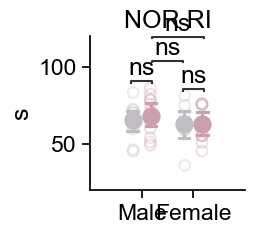

In [21]:
plot_events(ppi_nor, 'NOR_test_RI', '/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/NOR_RI.pdf', ylim=(20,120), title='NOR RI', ylabel='s')

# plotting PPI

/opt/anaconda3/envs/python3119/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/python3119/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


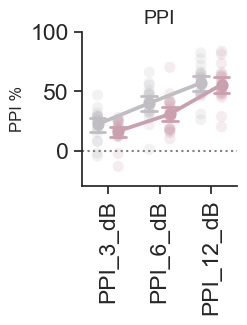

In [22]:
# read in ppi melt -- better format for plotting
melt_outcome = pd.read_excel('/Users/hannalemmik/Dropbox/KO_paper/data/PPI_melt.xlsx')
custom_palette = {'WT': '#c0bec2', 'C3aR -:Hom': '#cba0ae'}

sns.set_style('ticks')

plt.figure(figsize=(2, 2))

order=['WT', 'C3aR -:Hom']

stripplot = sns.stripplot(
    x='PPI_dB', 
    y='value',
    hue='Group_ID', 
    palette=custom_palette, 
    data=melt_outcome, 
    dodge=True,
    marker='o',                
    size=8,                   
    jitter=False,
    alpha=0.2,               
    hue_order=order, 
    linewidth=0,            
    zorder=1
)

sns.pointplot(x='PPI_dB', 
              y='value', 
              hue='Group_ID', 
              palette=custom_palette, 
              hue_order=order,
              data=melt_outcome, 
              errorbar=('ci', 95), 
              capsize=0.3, 
              scale=1, 
              dodge=0.4, 
              join=True, 
              errwidth=2)

plt.xlabel('', fontsize=12)
plt.ylabel('PPI %', fontsize=12)
plt.title('PPI', fontsize=14)
plt.xticks(rotation=90)  
# remove the legend
plt.legend().remove()

plt.ylim(-30,100)

sns.despine()
plt.axhline(y=0, color='gray', linestyle=':')

plt.savefig('/Users/hannalemmik/Dropbox/KO_paper/other_beh_comp/PPI.pdf')

# stats